After cleaning: (7919, 11)


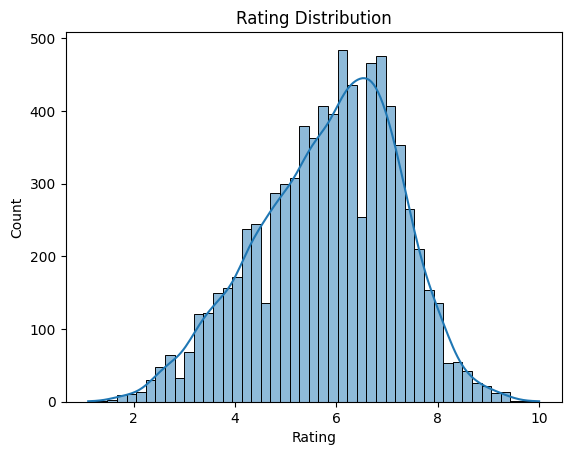

Baseline RMSE (mean): 1.365

Model Performance Comparison:
                   RMSE     R²
Model                         
Baseline (mean)   1.365 -0.002
RandomForest      0.631  0.786
GradientBoosting  0.618  0.794


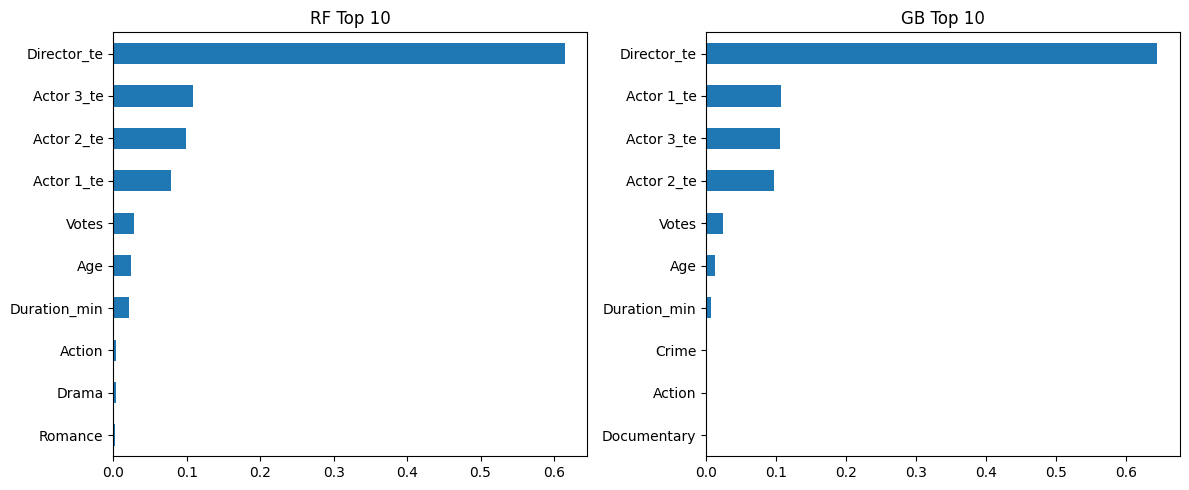

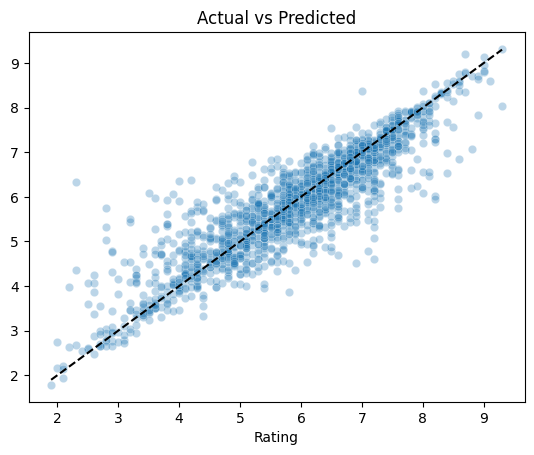

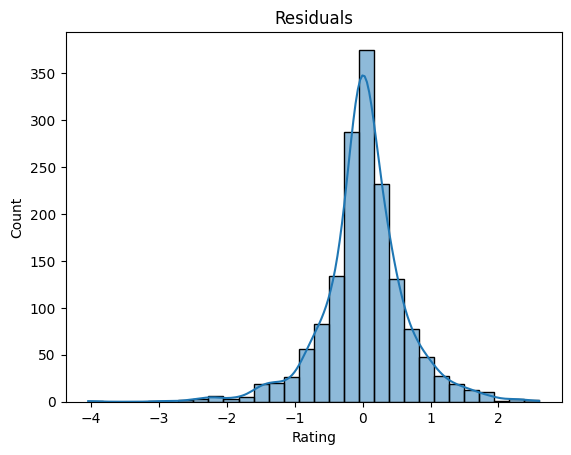

In [7]:

import pandas as pd
import numpy as np
import chardet
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


raw = open('IMDb Movies India.csv','rb').read(200000)
enc = chardet.detect(raw)['encoding']
df = pd.read_csv('IMDb Movies India.csv', encoding=enc)

df['Year']         = pd.to_numeric(df['Year'].str.extract(r'(\d{4})')[0], errors='coerce')
df['Duration_min'] = pd.to_numeric(df['Duration'].str.extract(r'(\d+)')[0], errors='coerce')
df[['Rating','Votes']] = df[['Rating','Votes']].apply(pd.to_numeric, errors='coerce')
df.dropna(subset=['Rating'], inplace=True)
df.reset_index(drop=True, inplace=True)
print("After cleaning:", df.shape)


sns.histplot(df['Rating'], kde=True); plt.title('Rating Distribution'); plt.show()


df['Age'] = 2025 - df['Year']
genre_dummies = df['Genre'].fillna('').str.get_dummies(sep=', ')
df = pd.concat([df, genre_dummies], axis=1)
for col in ['Director','Actor 1','Actor 2','Actor 3']:
    df[f'{col}_te'] = df.groupby(col)['Rating'].transform('mean')


features = (
    ['Duration_min','Votes','Age']
    + list(genre_dummies.columns)
    + [f'{c}_te' for c in ['Director','Actor 1','Actor 2','Actor 3']]
)
X = df[features]
y = df['Rating']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


mean_pred    = y_train.mean()
baseline_preds = np.full_like(y_test, mean_pred)
baseline_rmse  = np.sqrt(mean_squared_error(y_test, baseline_preds))
print(f"Baseline RMSE (mean): {baseline_rmse:.3f}")


rf_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestRegressor(n_estimators=100, random_state=42)
)
gbr_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    GradientBoostingRegressor(
        n_estimators=150, learning_rate=0.05, max_depth=5, random_state=42
    )
)


rf_pipe.fit(X_train, y_train)
rf_preds = rf_pipe.predict(X_test)

gbr_pipe.fit(X_train, y_train)
gbr_preds = gbr_pipe.predict(X_test)


results = []
for name, preds in [
    ('Baseline (mean)', baseline_preds),
    ('RandomForest',    rf_preds),
    ('GradientBoosting', gbr_preds)
]:
    rmse_val = np.sqrt(mean_squared_error(y_test, preds))
    r2_val   = r2_score(y_test, preds)
    results.append({'Model': name, 'RMSE': rmse_val, 'R²': r2_val})

results_df = pd.DataFrame(results).set_index('Model')
print("\nModel Performance Comparison:")
print(results_df.round(3))


imp_rf = pd.Series(
    rf_pipe.named_steps['randomforestregressor'].feature_importances_,
    index=features
).nlargest(10)
imp_gb = pd.Series(
    gbr_pipe.named_steps['gradientboostingregressor'].feature_importances_,
    index=features
).nlargest(10)

fig, ax = plt.subplots(1,2,figsize=(12,5))
imp_rf.sort_values().plot.barh(ax=ax[0], title='RF Top 10')
imp_gb.sort_values().plot.barh(ax=ax[1], title='GB Top 10')
plt.tight_layout(); plt.show()


best_preds = gbr_preds  # choose gbr or rf
sns.scatterplot(x=y_test, y=best_preds, alpha=0.3)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'k--')
plt.title('Actual vs Predicted'); plt.show()

resid = y_test - best_preds
sns.histplot(resid, bins=30, kde=True)
plt.title('Residuals'); plt.show()